# Development


## Basics and Commonalities

Before stepping into fitting development patterns, its worth reviewing the basics
of Estimators. The main modeling API implemented by chainladder follows that of
the scikit-learn estimator. An estimator is any object that learns from data.

### Scikit-Learn API

The scikit-learn API is a common modeling interface that is used to construct and
fit a countless variety of machine learning algorithms.  The common interface
allows for very quick swapping between models with minimal code changes.  The
``chainladder`` package has adopted the interface to promote a standardized approach
to fitting reserving models.

All estimator objects can optionally be configured with parameters to uniquely
specify the model being built.  This is done ahead of pushing any data through
the model.

```python
estimator = Estimator(param1=1, param2=2)
```
All estimator objects expose a `fit` method that takes a `Triangle` as input, `X`:

```python
estimator.fit(X=data)
```

All estimators include a `sample_weight` option to the `fit` method to specify
an exposure basis.  If an exposure base is not applicable, then this argument is
ignored.

```python
estimator.fit(X=data, sample_weight=weight)
```

All estimators either `transform` the input Triangle or `predict` an outcome.

### Transformers

All transformers include a ``transform`` method.  The method is used to transform a
Triangle and it will always return a Triangle with added features based on the
specifics of the transformer.

```python
transformed_data = estimator.transform(data)
```

Other than final IBNR models, ``chainladder`` estimators are transformers.
That is, they return your `Triangle` back to you with additional properties.

Transforming can be done at the time of fit.

```python
# Fitting and Transforming
estimator.fit(data)
transformed_data = estimator.transform(data)
# One line equivalent
transformed_data = estimator.fit_transform(data)
assert isinstance(transformed_data, cl.Triangle)
```

### Predictors

All predictors include a ``predict`` method.

```python
prediction = estimator.predict(new_data)
```

Predictors are intended to create new predictions. It is not uncommon to fit a
model on a more aggregate view, say national level, of data and predict on a
more granular triangle, state or provincial.

### Parameter Types

Estimator parameters: All the parameters of an estimator can be set when it is
instantiated or by modifying the corresponding attribute.  These parameters
define how you'd like to fit an estimator and are chosen before the fitting
process.  These are often referred to as hyperparameters in the context of
Machine Learning, and throughout these documents.  Most of the hyperparameters
of the ``chainladder`` package take on sensible defaults.

```python
estimator = Estimator(param1=1, param2=2)
assert estimator.param1 == 1
```

Estimated parameters: When data is fitted with an estimator, parameters are
estimated from the data at hand. All the estimated parameters are attributes
of the estimator object ending by an underscore.  The use of the underscore is
a key API design style of scikit-learn that allows for the quicker recognition
of fitted parameters vs hyperparameters:

```python
estimator.estimated_param_
```

In many cases the estimated parameters are themselves Triangles and can be
manipulated using the same methods we learned about in the `Triangle` class.



In [33]:
import chainladder as cl
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'


In [13]:
dev = cl.Development().fit(cl.load_sample('ukmotor'))
type(dev.cdf_)

chainladder.core.triangle.Triangle

### Commonalities

All "Development Estimators" are transformers and reveal common a set of properties
when they are fit.

1. ``ldf_`` represents the fitted age-to-age factors of the model.
2. ``cdf_`` represents the fitted age-to-ultimate factors of the model.
3. All "Development estimators" implement the ``transform`` method.


``cdf_`` is nothing more than the cumulative representation of the ``ldf_`` vectors.


In [14]:
dev = cl.Development().fit(cl.load_sample('raa'))
dev.ldf_.incr_to_cum() == dev.cdf_

True

(development:development)=
## Development

`Development` allows for the selection of loss development patterns. Many
of the typical averaging techniques are available in this class: ``simple``,
``volume`` and  ``regression`` through the origin. Additionally, `Development`
includes patterns to allow for fine-tuned exclusion of link-ratios from the LDF
calculation.


In [15]:
raa = cl.load_sample('raa')
cl.Development(average='simple')

Development(average='simple')

Alternatively, you can provide a list to parameterize each development period
separately.  When adjusting individual development periods the list must be
the same length as your triangles ``link_ratio`` development axis.

In [16]:
len(raa.link_ratio.development)

9

In [17]:
cl.Development(average=['volume']+['simple']*8)

Development(average=['volume', 'simple', 'simple', 'simple', 'simple', 'simple',
                     'simple', 'simple', 'simple'])

This approach works for ``average``, ``n_periods``, ``drop_high`` and ``drop_low``.

Notice where you have not specified a parameter, a sensible default
is chosen for you.

### Omitting link ratios

There are several arguments for dropping individual cells from the triangle as
well as excluding whole valuation periods or highs and lows.  Any combination
of the 'drop' arguments is permissible.


In [18]:
cl.Development(
    drop_high=[True]*5+[False]*4, 
    drop_low=[True]*5+[False]*4).fit(raa)

Development(drop_high=[True, True, True, True, True, False, False, False,
                       False],
            drop_low=[True, True, True, True, True, False, False, False, False])

In [19]:
cl.Development(drop_valuation='1985').fit(raa)


Development(drop_valuation='1985')

In [20]:
cl.Development(drop=[('1985', 12), ('1987', 24)]).fit(raa)

Development(drop=[('1985', 12), ('1987', 24)])

In [21]:
cl.Development(drop=('1985', 12), drop_valuation='1988').fit(raa)

Development(drop=('1985', 12), drop_valuation='1988')

When using `drop`, the earliest age of the `link_ratio` should be referenced.
For example, use `12` to drop the `12-24` ratio.

```{note}
`drop_high` and `drop_low` are ignored in cases where the number of link ratios available for a given development period is less than 1.


### Extended Link Ratio Family

The `Development` estimator is based on the regression framework known as the
Extended Link Ratio Family (ELRF).  A nice property of this family is that we
not only get estimates for our patterns (`cdf_`, and `ldf_`), but also
measures of variability of our estimates (`sigma_`, `std_err_` and `std_residuals_`
).  These variability properties are used to develop the stochastic features in the
`MackChainladder` method, but even for deterministic methods these variability
estimates can be used as a diagnostic tool to validate the appropriateness of using
multiplicative link ratios.

The `std_residuals_` in particular is described by Barnett and Zehnwirth as a diagnostic
that points to the inferiority of the chainladder method relative to the probablistic
trend family.

In [35]:
raa = cl.load_sample('raa')
model = cl.Development().fit(raa)
model.std_residuals_

,12,24,36,48,60,72,84,96,108
1981,-0.5722,-0.8317,-0.7489,-0.3442,0.8704,1.4143,-0.0003,-0.6819,
1982,2.3075,-0.7161,1.9716,1.5900,0.1982,-0.9488,1.0919,0.7315,
1983,-0.1267,-0.2299,-0.4811,-0.1780,0.9056,-0.2967,-0.8987,,
1984,-0.4305,-0.8365,0.3723,-1.3074,0.0012,-0.1064,,,
1985,1.1398,0.0943,0.6175,-0.0170,-1.5437,,,,
1986,0.2936,0.4633,-0.6809,0.7825,,,,,
1987,0.5961,2.0935,-0.5805,,,,,,
1988,0.4717,0.6607,,,,,,,
1989,-0.4282,,,,,,,,


 Replicating **Fig 2.6** from their paper can be accomplished with 
a bit of manipulation of the residual triangles.

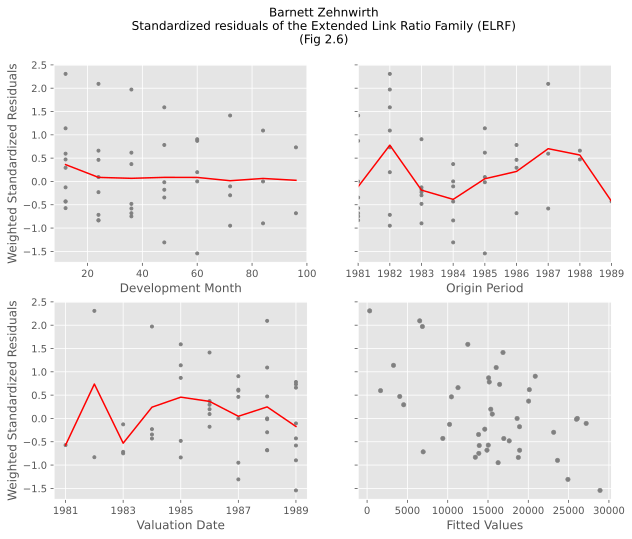

In [31]:
fig, ((ax00, ax01), (ax10, ax11)) = plt.subplots(ncols=2, nrows=2, figsize=(10,8))
model.std_residuals_.T.plot(
    style='.', color='gray', legend=False, grid=True, ax=ax00,
    xlabel='Development Month', ylabel='Weighted Standardized Residuals')
model.std_residuals_.iloc[..., :-1].mean('origin').T.plot(
    color='red', legend=False, grid=True, ax=ax00)
model.std_residuals_.plot(
    style='.', color='gray', legend=False, grid=True, ax=ax01, xlabel='Origin Period')
model.std_residuals_.mean('development').plot(
    color='red', legend=False, grid=True, ax=ax01)
model.std_residuals_.dev_to_val().T.plot(
    style='.', color='gray', legend=False, grid=True, ax=ax10,
    xlabel='Valuation Date', ylabel='Weighted Standardized Residuals')

model.std_residuals_.dev_to_val().mean('origin').T.plot(color='red', legend=False, grid=True, ax=ax10)
pd.concat((
    (raa[raa.valuation<raa.valuation_date]*model.ldf_.values).unstack().rename('Fitted Values'),
    model.std_residuals_.unstack().rename('Residual')), axis=1).dropna().plot(
    kind='scatter', marker='o', color='gray', x='Fitted Values', y='Residual', ax=ax11, grid=True, sharey=True)
fig.suptitle("Barnett Zehnwirth\nStandardized residuals of the Extended Link Ratio Family (ELRF)\n(Fig 2.6)");

These residual plots which should should look random are used to highlight whether
the chainladder model is violated.  Violations generally occur due to trends in the
valuation axis which are not accounted for in the basic chainladder method.

{cite}`barnett2000`

### Transforming

When transforming a `Triangle`, you will receive a copy of the original
triangle back along with the fitted properties of the `Development`
estimator.  Where the original Triangle contains all link ratios, the transformed
version recognizes any ommissions you specify.

In [ ]:
triangle = cl.load_sample('raa')
dev = cl.Development(drop=('1982', 12), drop_valuation='1988')
transformed_triangle = dev.fit_transform(triangle)
transformed_triangle.ldf_

In [ ]:
transformed_triangle.link_ratio.heatmap()

By decoupling the `fit` and `transform` methods, we can apply our `Development`
estimator to new data.  This is a common pattern of the scikit-learn API. In this
example we generate development patterns at an industry level and apply those
patterns to individual companies.

In [ ]:
clrd = cl.load_sample('clrd')
clrd = clrd[clrd['LOB']=='wkcomp']['CumPaidLoss']
# Summarize Triangle to industry level to estimate patterns
dev = cl.Development().fit(clrd.sum())
# Apply Industry patterns to individual companies
dev.transform(clrd)

### Groupby

Triangles have a `groupby` method that follows pandas syntax and this allows for aggregating
triangle data to a more reasonable level for any particular analysis.  However, it is often 
the desire of an actuary to estimate development factors at a more aggregate grain generally 
and then apply it to a more detailed triangle.

We can, for example, pick volume-weighted development patterns at a Line of Business level
and subsequently apply them to each company within the line of business as follows:

In [39]:
clrd = cl.load_sample('clrd')['CumPaidLoss']
clrd = cl.Development(groupby='LOB').fit_transform(clrd)

clrd.shape, clrd.ldf_.shape

((775, 1, 10, 10), (6, 1, 1, 9))

Notice we've retained the grain of the original triangle, but there are six 
sets of development patterns, one for each line of business.  Using this
transformed triangle in an IBNR esimtator will result in IBNR at the original grain 
but using patterns at the Line of Business grain.

It is worth noting that fitting and transforming are entirely decoupled from one another, and we could
achieve the same outcome by directly aggregating the Triangle before passing to the fit method.

In [44]:
clrd = cl.load_sample('clrd')['CumPaidLoss']
model = cl.Development().fit(clrd.groupby('LOB').sum())
clrd = model.transform(clrd)

clrd.shape, clrd.ldf_.shape

((775, 1, 10, 10), (6, 1, 1, 9))

This begs the question, why do we need a `groupby` hyperparameter as part of the `Development` estimator when we can aggregate the Triangle before fitting?  In more advanced situations, we will be creating compound estimators called `Pipelines` which are very powerful for building custom workflows, but with the limitation that
fitting and transforming have to be coupled together. You can explore this in more detail in the 
[Pipeline section](workflow:pipeline).

(development:developmentconstant)=
## DevelopmentConstant

The `DevelopmentConstant` estimator simply allows you to hard code development
patterns into a Development Estimator.  A common example would be to include a
set of industry development patterns in your workflow that are not directly
estimated from any of your own data.

In [ ]:
triangle = cl.load_sample('ukmotor')
patterns={12: 2, 24: 1.25, 36: 1.1, 48: 1.08, 60: 1.05, 72: 1.02}
cl.DevelopmentConstant(patterns=patterns, style='ldf').fit(triangle).ldf_

By wrapping patterns in the `DevelopmentConstant` estimator, we can integrate
into a larger workflow with tail extrapolation and IBNR calculations.

### Examples


::::{grid}
:gutter: 2

:::{grid-item-card} 
:columns: 4
:link: ../gallery/plot_callable_dev_constant
:link-type: doc
**DevelopmentConstant Callable**
```{image} ../images/plot_callable_dev_constant.png
---
alt: DevelopmentConstant Callable
---
```
+++
{bdg-warning}`hard`
:::
::::

(development:incrementaladditive)=
## IncrementalAdditive


The `IncrementalAdditive` method uses both the triangle of incremental
losses and the exposure vector for each accident year as a base. Incremental
additive ratios are computed by taking the ratio of incremental loss to the
exposure (which has been adjusted for the measurable effect of inflation), for
each accident year. This gives the amount of incremental loss in each year and
at each age expressed as a percentage of exposure, which we then use to square
the incremental triangle.

In [ ]:
tri = cl.load_sample("ia_sample")
ia = cl.IncrementalAdditive().fit(
    X=tri['loss'], 
    sample_weight=tri['exposure'].latest_diagonal)
ia.incremental_.round(0)

These `incremental_` values are then used to determine an implied set of
mutiplicative development patterns.  Because incremental additive values are
unique for each `origin`, so too will be the `ldf_`.

In [ ]:
ia.ldf_

### Incremental calculation
The estimation of the incremental triangle can be done with varying hyperparameters
of `n_period` and `average` similar to the `Development` estimator.  Additionally,
a `trend` in the origin period can also be selected.

Suppose there is a vector `zeta_` that represents an estimate of the incremental
losses, `X` for a development period as a percentage of some exposure or `sample_weight`.
Using a 'volume' weighted estimate for all origin periods, we can manually estimate `zeta_`.

In [ ]:
zeta_ = tri['loss'].cum_to_incr().sum('origin') / tri['exposure'].sum('origin')
zeta_

The `zeta_` vector along with the `sample_weight` and optionally a `trend`
are used to propagate incremental losses to the lower half of the `Triangle`.
In the trivial case of no trend, we can estimate the incrementals for age 72.

In [ ]:
zeta_.loc[..., 72] * tri['exposure'].latest_diagonal

These are the same incrementals that the IncrementalAdditive method produces.

In [ ]:
zeta_.loc[..., 72]*tri['exposure'].latest_diagonal == ia.incremental_.loc[..., 72]

### Trending

The `IncrementalAdditive` method supports trending through the `trend`
and the `future_trend` hyperparameters.  The `trend` parameter is used in the
fitting of `zeta_` and it trends all inner diagonals of the `Triangle` to its
`latest_diagonal` before estimating `zeta_`.

The `future_trend` hyperparameter is used to trend beyond the `latest_diagonal`
into the lower half of the `Triangle`.  If no future trend is supplied, then
the `future_trend` is assumed to be that of the `trend` parameter.

In [ ]:
cl.IncrementalAdditive(trend=0.02, future_trend=0.05).fit(
    X=tri['loss'], 
    sample_weight=tri['exposure'].latest_diagonal
).incremental_.round(0)

```{note}
These trend assumptions are applied to the incremental Triangle which produces
drastically different answers from the same trends applied to a cumulative Triangle.
```

A nice property of this estimator is that it really only requires incremental amounts
so a `Triangle` that has cumulative data censored data in earlier diagonals can
leverage this method.  Another nice property is that it allows for more explicit recognition
of future inflation in your estimate via the `trend` factor.



  {cite}`schmidt2006`

(development:munichadjustment)=
## MunichAdjustment

The `MunichAdjustment` is a bivariate adjustment to loss development factors.
There is a fundamental correlation between the paid and the case incurred data
of a triangle. The ratio of paid to incurred **(P/I)** has information that can
be used to simultaneously adjust the basic development factor selections for the
two separate triangles.

Depending on whether the momentary **(P/I)** ratio is below or above average,
one should use an above-average or below-average paid development factor and/or
a below-average or above-average incurred development factor.  In doing so, the
model replaces a set of development patterns that would be used for all
`origins` with individualized development curves that reflect the unique levels
of **(P/I)** per origin period.

### BerquistSherman Comparison

This method is similar to the `BerquistSherman` approach in that it tries to
adjust for case reserve adequacy.  However it is different in two distinct ways.

  1.  The `BerquistSherman` method is a direct adjustment to the data whereas
      the [MunichAdjustment](modules/generated/chainladder.MunichAdjustment) keeps the `Triangle` intact and adjusts the development
      patterns.
  2.  The [MunichAdjustment](modules/generated/chainladder.MunichAdjustment) is built in the context of a stochastic framework.

### Residuals

The [MunichAdjustment](modules/generated/chainladder.MunichAdjustment) uses the correlation between the residuals of the
univariate (basic) model and the (P/I) model.  These correlations spin off a
property ``lambda_`` which is represented by the line through the origin of
the correlation plots.

With the correlations, `lambda_` known, the basic development patterns can
be adjusted based on the **(P/I)** ratio at any given cell of the `Triangle`.

### Examples



`````{grid}
:gutter: 2

````{grid-item-card}
**[MunichAdjustment Residuals](plot_munich_resid)**
```{glue:} plot_munich_resid
```
+++
{bdg-warning}`medium`
````

````{grid-item-card}
**[MunichAdjustment Basics](plot_munich)**
```{glue:} plot_munich
```
+++
{bdg-success}`easy`

````
`````

{cite}`quarg2004`

(development:clarkldf)=
## ClarkLDF

`ClarkLDF` estimates growth curves of the form 'loglogistic' or 'weibull'
for the incremental loss development of a `Triangle`.  These growth curves are
monotonic increasing and are more relevant for paid data.  While the model can
be used for case incurred data, if there is too much "negative" development,
other Estimators should be used.

The `Loglogistic` Growth Function:

$G(x|\omega, \theta) =\frac{x^{\omega }}{x^{\omega } + \theta^{\omega }}$

The ``Weibull`` Growth Function:

$G(x|\omega, \theta) =1-exp(-\left (\frac{x}{\theta}  \right )^\omega)$


Parameterized growth curves can produce patterns for any age and can even be used
to estimate a tail beyond the latest age in a Triangle.  In general, the
loglogistic growth curve produces a larger tail than the weibull growth curve.

### LDF and Cape Cod methods

Clark approaches curve fitting with two different methods, an LDF approach and
a Cape Cod approach.  The LDF approach only requires a loss triangle whereas
the Cape Cod approach would also need a premium vector.  Choosing between the
two methods occurs at the time you fit the estimator.  When a premium vector
is included, the Cape Cod method is invoked.

A simple example of using `ClarkLDF` LDF Method. Upon fitting the Estimator,
we obtain both `omega_` and `theta_`.


In [ ]:
clrd = cl.load_sample('clrd').groupby('LOB').sum()
dev = cl.ClarkLDF(growth='weibull').fit(clrd['CumPaidLoss'])
dev.omega_

Perhaps more useful than the parameters is the growth curve `G_` function they
represent which can be used to deetermine the development factor at any age.

In [ ]:
1/dev.G_(37.5).to_frame()

Another example showing the usage of the `ClarkLDF` Cape Cod approach. With
the Cape Cod, an Expected Loss Ratio is included as an extra feature in the `elr_` property.

In [ ]:
cl.ClarkLDF().fit(
    X=clrd['CumPaidLoss'], 
    sample_weight=clrd['EarnedPremDIR'].latest_diagonal
).elr_

### Residuals

Clark's model assumes Incremental losses are independent and identically
distributed.  To ensure compatibility with this assumption, he suggests
reviewing the "Normalized Residuals" of the fitted incremental losses to ensure
the assumption is not violated.

### Stochastics

Using MLE to solve for the growth curves, we can produce statistics about the
parameter and process uncertainty of our model.

### Examples

::::{grid}
:gutter: 2

:::{grid-item-card} 
:columns: 4
:link: ../gallery/plot_clarkldf_resid
:link-type: doc
**ClarkLDF Residuals**
```{image} ../images/plot_clarkldf_resid.png
---
alt: ClarkLDF Residuals
---
```
+++
{bdg-warning}`medium`
:::

:::{grid-item-card} 
:columns: 4
:link: ../gallery/plot_clarkldf
:link-type: doc
**ClarkLDF Growth Curves**
```{image} ../images/plot_clarkldf.png
---
alt: ClarkLDF Residuals
---
```
+++
{bdg-warning}`easy`
:::
::::

{cite}`clark2003`

(development:caseoutstanding)=
## CaseOutstanding


The `CaseOutstanding` method is a deterministic method that estimates
incremental payment patterns from prior lag carried case reserves.  Included
in this is also patterns for the carried case reserves based on the prior lag
carried case reserve.

Like the [MunichAdjustment](modules/generated/chainladder.MunichAdjustment) and `BerquistSherman`, this estimator
is useful when you want to incorporate information about case reserves into paid
ultimates.

To use it, a triangle with both paid and incurred amounts must be available.

In [ ]:
tri = cl.load_sample('usauto')
model = cl.CaseOutstanding(paid_to_incurred=('paid', 'incurred')).fit(tri)
model.paid_ldf_

In the example above, the incremental paid losses during the period 12-24 is expected to be
84.28% of the outstanding case reserve at lag 12.  The set of patterns produced by
`CaseOutstanding` don't follow the multiplicative approach commonly used in the
various IBNR methods making them not directly usable.  Because of this, the estimator
determines the 'implied' multiplicative pattern so that a broader set of IBNR
methods can be used.  Due to the origin period specifics on case reserves, each
origin gets its own set of multiplicative `ldf_` patterns.

In [24]:
model.ldf_['paid']

,12-24,24-36,36-48,48-60,60-72,72-84,84-96,96-108,108-120
1998,1.7925,1.2056,1.0956,1.0457,1.0189,1.0097,1.0048,1.0023,1.0019
1999,1.7683,1.1986,1.0902,1.0435,1.0194,1.0092,1.0050,1.0024,1.0019
2000,1.7620,1.1902,1.0900,1.0430,1.0191,1.0101,1.0046,1.0024,1.0020
2001,1.7439,1.1913,1.0906,1.0436,1.0187,1.0090,1.0042,1.0021,1.0017
2002,1.7348,1.1940,1.0892,1.0442,1.0186,1.0085,1.0041,1.0020,1.0016
2003,1.7189,1.1853,1.0920,1.0438,1.0186,1.0092,1.0045,1.0022,1.0018
2004,1.7025,1.1867,1.0922,1.0415,1.0179,1.0088,1.0043,1.0021,1.0017
2005,1.7012,1.1860,1.0859,1.0412,1.0177,1.0087,1.0042,1.0021,1.0017
2006,1.7028,1.1797,1.0857,1.0411,1.0177,1.0087,1.0042,1.0021,1.0017
2007,1.6693,1.1804,1.0860,1.0412,1.0178,1.0087,1.0042,1.0021,1.0017


### Incremental patterns

The incremental patterns of the `CaseOutstanding` method are avilable as
additional properties for review. They are the `paid_to_prior_case_` and the
`case_to_prior_case_`. These are useful to review when deciding on the appropriate
hyperparameters for `paid_n_periods` and `case_n_periods`.  Once you are satisfied
with your hyperparameter tuning, you can see the fitted selections in the
`paid_ldf_` and `case_ldf_` incremental patterns.

In [25]:
model.case_to_prior_case_

,24-36,36-48,48-60,60-72,72-84,84-96,96-108,108-120,120-132
1998,0.5378,0.5541,0.5253,0.4981,0.5329,0.5380,0.5877,0.6970,0.5798
1999,0.5368,0.5649,0.5442,0.4969,0.5029,0.5800,0.6420,0.6506,
2000,0.5461,0.5742,0.5391,0.4872,0.5376,0.5432,0.6655,,
2001,0.5406,0.5660,0.5148,0.5013,0.5077,0.5414,,,
2002,0.5409,0.5546,0.5406,0.4802,0.4881,,,,
2003,0.5265,0.5765,0.5363,0.4764,,,,,
2004,0.5298,0.5665,0.5069,,,,,,
2005,0.5215,0.5539,,,,,,,
2006,0.5261,,,,,,,,
2007,,,,,,,,,


In [26]:
model.case_ldf_

,24-36,36-48,48-60,60-72,72-84,84-96,96-108,108-120,120-132
(All),0.5340,0.5638,0.5296,0.4900,0.5139,0.5506,0.6317,0.6738,0.5798


{cite}`friedland2010`

(development:tweedieglm)=
## TweedieGLM

The `TweedieGLM` implements the GLM reserving structure discussed by Taylor and McGuire.
A nice property of the GLM framework is that it is highly flexible in terms of including
covariates that may be predictive of loss reserves while maintaining a close relationship
to traditional methods.  Additionally, the framework can be extended in a straightforward
way to incorporate various approaches to measuring prediction errors.  Behind the
scenes, `TweedieGLM` is using scikit-learn's `TweedieRegressor` estimator.

### Long Format

GLMs are fit to triangles in "Long Format".  That is, they are converted to pandas
DataFrames behind the scenes.  Each axis of the `Triangle` is included in the
dataframe. The ``origin`` and ``development`` axes are in columns of the same name.
You can inspect what your `Triangle` looks like in long format by calling `to_frame`
with ``keepdims=True``


In [27]:
cl.load_sample('clrd').to_frame(keepdims=True).reset_index().head()

,GRNAME,LOB,origin,development,IncurLoss,CumPaidLoss,BulkLoss,EarnedPremDIR,EarnedPremCeded,EarnedPremNet
0,Adriatic Ins Co,othliab,1995-01-01,12,8.0,NaN,8.0,139.0,131.0,8.0
1,Adriatic Ins Co,othliab,1995-01-01,24,11.0,NaN,4.0,139.0,131.0,8.0
2,Adriatic Ins Co,othliab,1995-01-01,36,7.0,3.0,4.0,139.0,131.0,8.0
3,Adriatic Ins Co,othliab,1996-01-01,12,40.0,NaN,40.0,410.0,359.0,51.0
4,Adriatic Ins Co,othliab,1996-01-01,24,40.0,NaN,40.0,410.0,359.0,51.0


```{warning}
'origin', 'development', and 'valuation' are reserved keywords for the dataframe.  Declaring columns with these names separately will result in error.
```

While you can inspect the `Triangle` in long format, you will not directly convert
to long format yourself.  The `TweedieGLM` does this for you.  Additionally,
the `origin` of the design matrix is restated in years from the earliest origin
period.  That is, is if the earliest origin is '1995-01-01' then it gets replaced with
0.  Consequently, '1996-04-01' would be replaced with 1.25. This is done because
datetimes have limited support in scikit-learn. Finally, the `TweedieGLM`
will automatically convert the response to an incremental basis.

### R-style formulas

We use the `patsy` library to allow formulation of the the feature set `X`
of the GLM.  Because `X` is a parameter that used extensively throughout
`chainladder`, the `TweedieGLM` refers to it as the `design_matrix`.  Those
familiar with the R programming language will be familiar with the notation
used by `patsy`.  For example, we can include both `origin` and `development`
as terms in a model.

In [28]:
genins = cl.load_sample('genins')
glm = cl.TweedieGLM(design_matrix='development + origin').fit(genins)
glm.coef_

,coef_
Intercept,13.516322
development,-0.006251
origin,0.033863


### ODP Chainladder

Replicating the results of the volume weighted chainladder development patterns
can be done by fitting a Poisson-log GLM to incremental paids.  To do this, we
can specify the `power` and `link` of the estimator as well as the `design_matrix`.
The volume-weighted chainladder method can be replicated by including both
`origin` and `development` as categorical features.

In [29]:
dev = cl.TweedieGLM(
    design_matrix='C(development) + C(origin)',
    power=1, link='log').fit(genins)

A trivial comparison against the traditional `Development` estimator shows
a comparable set of `ldf_` patterns.


### Parsimonious modeling

Having full access to all axes of the `Triangle` along with the powerful formulation
of `patsy` allows for substantial customization of the model fit.  For example,
we can include 'LOB' interactions with piecewise linear coefficients to reduce
model complexity.


In [30]:
clrd = cl.load_sample('clrd')['CumPaidLoss'].groupby('LOB').sum()
clrd=clrd[clrd['LOB'].isin(['ppauto', 'comauto'])]
dev = cl.TweedieGLM(
    design_matrix='LOB+LOB:C(np.minimum(development, 36))+LOB:development+LOB:origin',
    max_iter=1000).fit(clrd)
dev.coef_

,coef_
Intercept,12.549945
LOB[T.ppauto],3.202703
"LOB[comauto]:C(np.minimum(development, 36))[T.24]",0.578694
"LOB[ppauto]:C(np.minimum(development, 36))[T.24]",0.449832
"LOB[comauto]:C(np.minimum(development, 36))[T.36]",0.790516
"LOB[ppauto]:C(np.minimum(development, 36))[T.36]",0.321206
LOB[comauto]:development,-0.044627
LOB[ppauto]:development,-0.054814
LOB[comauto]:origin,0.054581
LOB[ppauto]:origin,0.057790


This model is limited to 10 coefficients across two lines of business.  The basic
chainladder model is known to be overparameterized with at least 18 parameters
requiring estimation. Despite drastically simplifying the model, the `cdf_`
patterns of the GLM are within 1% of the traditional chainladder for every lag
and for both lines of business:

In [31]:
((dev.cdf_.iloc[..., 0, :] / 
  cl.Development().fit(clrd).cdf_) - 1
).to_frame().round(3)

development,12-Ult,24-Ult,36-Ult,48-Ult,60-Ult,72-Ult,84-Ult,96-Ult,108-Ult
LOB,,,,,,,,,
comauto,0.002,0.003,-0.01,0.003,0.011,0.008,0.005,-0.000,-0.002
ppauto,0.006,0.003,-0.00,0.001,0.002,0.001,0.001,0.001,0.001


Like every other Development estimator, the `TweedieGLM` produces a set of `ldf_`
patterns and can be used in a larger workflow with tail extrapolation and reserve
estimation.

::::{grid}
:gutter: 2

:::{grid-item-card} 
:columns: 4
:link: ../gallery/plot_glm_ldf
:link-type: doc
**TweedieGLM Basics**
```{image} ../images/plot_glm_ldf.png
---
alt: TweedieGLM Basics
---
```
+++
{bdg-warning}`easy`
:::
::::


{cite}`taylor2016`

(development:developmentml)=
## DevelopmentML

`DevelopmentML` is a general development estimator that works as an interface to
scikit-learn compliant machine learning (ML) estimators.  The `TweedieGLM` is
a special case of `DevelopmentML` with the ML algorithm limited to scikit-learn's
`TweedieRegressor` estimator.

### The Interface

ML algorithms are designed to be fit against tabular data like a pandas DataFrame
or a 2D numpy array.  A `Triangle` does not meet the definition and so `DevelopmentML`
is provided to incorporate ML into a broader reserving workflow. This includes:

  1. Automatic conversion of Triangle to a dataframe for fitting
  2. Flexibility in expressing any preprocessing as part of a scikit-learn `Pipeline`
  3. Predictions through the terminal development age of a `Triangle` to fill in the
     lower half
  4. Predictions converted to `ldf_` patterns so that the results of the estimator
     are compliant with the rest of `chainladder`, like tail selection and IBNR modeling.

### Features

Data from any axis of a `Triangle` is available to be used in the `DevelopmentML`
estimator.  For example, we can use many of the scikit-learn components to
generate development patterns from both the time axes as well as the `index` of
the `Triangle`.

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

clrd = cl.load_sample('clrd').groupby('LOB').sum()['CumPaidLoss']

# Decide how to preprocess the X (ML) dataset using sklearn
design_matrix = ColumnTransformer(transformers=[
    ('dummy', OneHotEncoder(drop='first'), ['LOB', 'development']),
    ('passthrough', 'passthrough', ['origin'])
])

# Wrap preprocessing and model in a larger sklearn Pipeline
estimator_ml = Pipeline(steps=[
    ('design_matrix', design_matrix),
    ('model', RandomForestRegressor())
])

# Fitting DevelopmentML fits the underlying ML model and gives access to ldf_
cl.DevelopmentML(estimator_ml=estimator_ml, y_ml='CumPaidLoss').fit(clrd).ldf_

,Triangle Summary
Valuation:,2261-12
Grain:,OYDY
Shape:,"(6, 1, 10, 9)"
Index:,[LOB]
Columns:,[CumPaidLoss]


### Autoregressive

The time-series nature of loss development naturally lends to an urge for autoregressive
features.  That is, features that are based on predictions, albeit on a lagged basis.
`DevelopmentML` includes an `autoregressive` parameter that can be used to
express the response as a lagged feature as well.

```{note}
When using `autoregressive` features, you must also declare it as a column
in your `estimator_ml` Pipeline.
```

### PatsyFormula

While the sklearn preprocessing API is powerful, it can be tedious work with in
some instances. In particular, modeling complex interactions is much easier to do
with Patsy.  The `chainladder` package includes a custom sklearn estimator
to gain access to the patsy API.  This is done through the `PatsyFormula` estimator.

In [33]:
estimator_ml = Pipeline(steps=[
    ('design_matrix', cl.PatsyFormula('LOB:C(origin)+LOB:C(development)+development')),
    ('model', RandomForestRegressor())
])
cl.DevelopmentML(
    estimator_ml=estimator_ml, 
    y_ml='CumPaidLoss').fit(clrd).ldf_.iloc[0, 0, 0].round(2)

,12-24,24-36,36-48,48-60,60-72,72-84,84-96,96-108,108-120
(All),2.6500,1.4100,1.1900,1.1000,1.0400,1.0200,1.0100,1.0100,1.0100


```{note}
`PatsyFormula` is not an estimator designed to work with triangles.  It is an sklearn transformer designed to work with pandas DataFrames allowing it to work directly in an sklearn Pipeline.
```

(development:barnettzehnwirth)=
## BarnettZehnwirth

The `BarnettZehnwirth` estimator solves for development patterns using the
Probabilistic Trend Family (PTF) regression framework.  Unlike the ELRF framework,
which assumes no ``valuation`` covariate, the PTF framework allows for this.

```{eval-rst}
.. figure:: ../images/prob_trend_family.PNG
   :align: center
   :scale: 40%
```

Structurally, the PTF regression is different from the `ELRF` (ELRF) regression framework in
two distinct ways:

  1. Where the ELRF fits independent regressions to each adjacent development lag, the PTF
     regression is fit to the entire triangle
  2. Where the ELRF is fit to cumulative amounts, the PTF is fit to the log of
     the incremental amounts of the `Triangle`.

### Formulation

The PTF framework is an ordinary least squares (OLS) model with the response, `y`
being the log of the incremental amounts of a Triangle. These are assumed to be
normally distributed which implies the incrementals themselves are log-normal
distributed.

The framework includes coefficients for origin periods (alpha), development periods (gamma)
and calendar period (iota).


$y(i, j) = \alpha _{i} + \sum_{k=1}^{j}\gamma _{k}+ \sum_{\iota =1}^{i+j}\gamma _{\iota}+ \varepsilon  _{i,j}$

These coefficients can be categorical or continuous, and to support a wide range of
model forms, patsy formulas are used.


In [34]:
abc = cl.load_sample('abc')

# Discrete origin, development, valuation
cl.BarnettZehnwirth(formula='C(origin)+C(development)').fit(abc).coef_.T

,Intercept,C(origin)[T.1.0],C(origin)[T.2.0],C(origin)[T.3.0],C(origin)[T.4.0],C(origin)[T.5.0],C(origin)[T.6.0],C(origin)[T.7.0],C(origin)[T.8.0],C(origin)[T.9.0],...,C(development)[T.24],C(development)[T.36],C(development)[T.48],C(development)[T.60],C(development)[T.72],C(development)[T.84],C(development)[T.96],C(development)[T.108],C(development)[T.120],C(development)[T.132]
coef_,11.836863,0.178824,0.345112,0.378133,0.405093,0.427041,0.431076,0.660383,0.963223,1.1568,...,0.251091,-0.055824,-0.448589,-0.828917,-1.16913,-1.507561,-1.798345,-2.0231,-2.238333,-2.427672


In [35]:
# Linear coefficients for origin, development, and valuation
cl.BarnettZehnwirth(formula='origin+development+valuation').fit(abc).coef_.T

,Intercept,origin,development,valuation
coef_,8.359157,4.215981,0.319288,-4.116569


The PTF framework is particularly useful when there is calendar period inflation
influences on loss development.

::::{grid}
:gutter: 2

:::{grid-item-card} 
:columns: 4
:link: ../gallery/plot_ptf_resid
:link-type: doc
**PTF Residuals**
```{image} ../images/plot_ptf_resid.png
---
alt: PTF Residuals
---
```
+++
{bdg-warning}`medium`
:::
::::

{cite}`barnett2000`